In [1]:
import numpy as np
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
from ieeg.auth import Session
from scipy import signal as sig
import scipy as sc
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF,ConstantKernel
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import normalize
import os
from os.path import join as ospj
from os.path import exists as ospe
import pathlib
from tqdm import tqdm
from utils import *
import sys
sys.path.append('/users/wojemann/iEEG_processing')
from pioneer import Pioneer
import mne

## Seizure Preprocessing

### Pulling patient metadata

In [2]:
def optimize_localizations(path_to_recon,RID):
    atropos_metadata = pd.read_json(path_to_recon + f'sub-RID0{RID}_ses-clinical01_space-T00mri_atlas-atropos_radius-2_desc-vox_coordinates.json',lines=True)
    localization_probs = pd.read_json(path_to_recon + f'sub-RID0{RID}_ses-clinical01_space-T00mri_atlas-DKTantspynet_radius-2_desc-vox_coordinates.json',lines=True)
    localization_metadata = pd.read_csv(path_to_recon + f'sub-RID0{RID}_ses-clinical01_space-T00mri_atlas-DKTantspynet_radius-2_desc-vox_coordinates.csv')
    def _apply_function(x):
        # look in labels sorted and see if it contains gray matter
        # if gray matter is greater than 5% then set label to gray matter
        x = pd.DataFrame(x).transpose()
        for i,label in enumerate(x['labels_sorted'].to_numpy()[0]):
            if (label == 'gray matter') and (x['percent_assigned'].to_numpy()[0][i] > 0.05):
                x['label'] = label
                x['index'] = 2
                continue
            elif (label == 'white matter') and (x['percent_assigned'].to_numpy()[0][i] > 0.05):
                x['label'] = label
                x['index'] = 3
        
        return x

    modified_atropos = atropos_metadata.iloc[:,:].apply(lambda x: _apply_function(x), axis = 1)
    modified_atropos_df = pd.DataFrame(np.squeeze(np.array(modified_atropos.to_list())),columns=atropos_metadata.columns)
    return modified_atropos_df
    
    # mask = (atropos_metadata['index'] == 2)
    # localization_metadata.loc[mask,'label'] = localization_probs[mask]['labels_sorted'].apply(lambda x: next((label for label in x if label != "EmptyLabel"), "EmptyLabel"))
    # return localization_metadata

In [3]:
np.random.seed(42)

with open('config.json','r') as f:
    CONFIG = json.load(f)
usr = CONFIG["paths"]["iEEG_USR"]
pass_path = CONFIG["paths"]["iEEG_PWD"]
datapath = CONFIG["paths"]["RAW_DATA"]
ieeg_list = CONFIG["patients"]
rid_hup = pd.read_csv(ospj(datapath,'rid_hup.csv'))
pt_list = np.unique(np.array([i.split("_")[0] for i in ieeg_list]))
# Iterate through each patient
for pt in tqdm([pt_list[0]]):
    raw_datapath = ospj(datapath,pt)
    # load dataframe of seizure times
    seizure_times = pd.read_csv(ospj(raw_datapath,f"seizure_times_{pt}.csv"))
    # load electrode information
    if not os.path.exists(ospj(raw_datapath, "electrode_localizations.csv")):
        hup_no = pt[3:]
        rid = rid_hup[rid_hup.hupsubjno == hup_no].record_id.to_numpy()[0]
        recon_path = ospj('/mnt','leif','littlab','data',
                          'Human_Data','CNT_iEEG_BIDS',
                          f'sub-RID0{rid}','derivatives','ieeg_recon',
                          'module3/')
        electrode_localizations = optimize_localizations(recon_path,rid)
        electrode_localizations.to_csv(ospj(raw_datapath,"electrode_localizations.csv"))
    else:    
        electrode_localizations = pd.read_csv(ospj(raw_datapath,"electrode_localizations.csv"))
    ch_names = electrode_localizations[(electrode_localizations['index'] == 2) | (electrode_localizations['index'] == 3)]["name"]
    ch_names_clean = clean_labels(ch_names,pt)
    if not os.path.exists(ospj(raw_datapath, "seizures")):
        os.mkdir(ospj(raw_datapath, "seizures"))

100%|██████████| 1/1 [00:00<00:00, 50.04it/s]


### Pulling and saving seizures

In [4]:
# Code for within each patient's for loop
for i_sz,row in tqdm(seizure_times.iterrows()):
    if os.path.exists(ospj(raw_datapath,"seizures",f"seizure_{i_sz}_stim_{row.stim}.csv")):
        seizure = pd.read_csv(ospj(raw_datapath,"seizures",f"seizure_{i_sz}_stim_{row.stim}.csv"))
        fs = seizure.pop('fs').to_numpy()[0]
        break
    else:
        seizure,fs = get_iEEG_data(usr,pass_path,
                                    row.IEEGname,
                                    row.start*1e6,
                                    row.end*1e6,
                                    ch_names_clean)
        save_seizure = pd.concat((seizure,pd.DataFrame(np.ones(len(seizure),)*fs,columns=['fs'])),axis = 1)
        save_seizure.to_csv(ospj(raw_datapath,"seizures",f"seizure_{i_sz}_stim_{row.stim}.csv"),index=False)
        break

0it [00:01, ?it/s]


### Filtering

In [5]:
notch_seizure = notch_filter(seizure.to_numpy(),fs)
band_seizure = bandpass_filter(notch_seizure,fs)
car_seizure = band_seizure - np.mean(band_seizure, axis=0)
processed_seizure = pd.DataFrame(car_seizure,columns=seizure.columns)

In [6]:
t = np.arange(0,len(seizure)/fs,1/fs)

(<Figure size 825.586x2563.2 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8ae00516d8>)

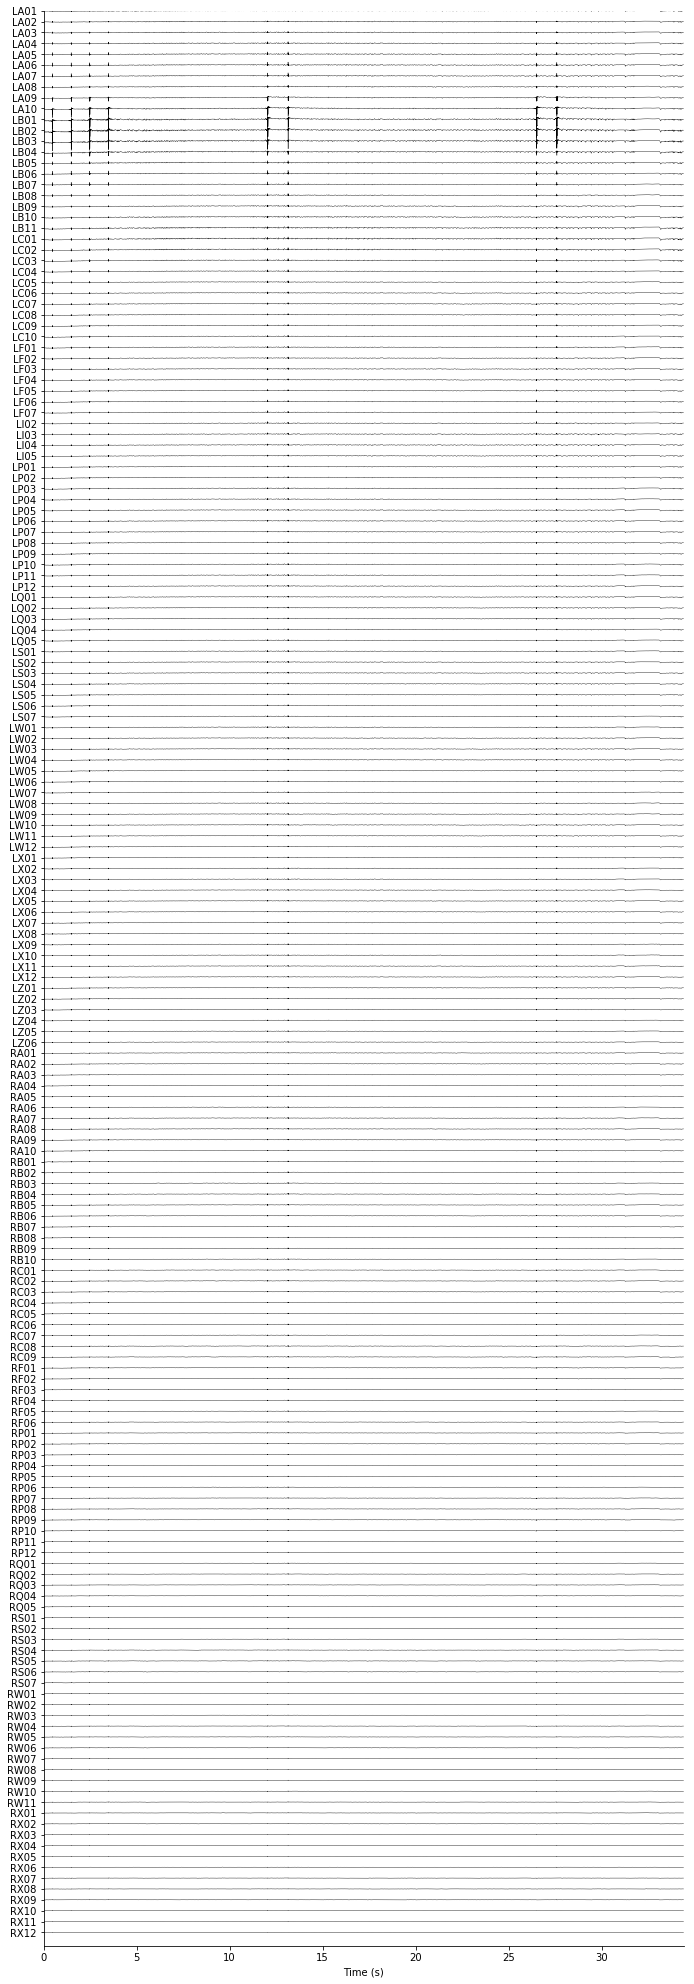

In [7]:
# plt.plot(np.arange(0,len(seizure)/fs,1/fs).T,seizure.to_numpy())
plot_iEEG_data(processed_seizure,t)

### Stim Artifact Removal

In [8]:
def artifact_removal(
    data: np.ndarray, fs: float, discon=1 / 12, noise=15000, win_size=1
) -> np.ndarray:
    """_summary_

    Args:
        data pandas
        fs (float): _description_
        discon (_type_, optional): _description_. Defaults to 1/12.
        noise (int, optional): _description_. Defaults to 15000.
        win_size (int, optional): _description_. Defaults to 1.

    Returns:
        np.ndarray: _description_
    """
    win_size = int(win_size * fs)
    
    n_wins = np.ceil(data.shape[0]/win_size)
    max_inds = n_wins*win_size
     
    all_inds = np.arange(max_inds)
    all_inds[data.shape[0]:] = np.nan
    ind_overlap = np.reshape(all_inds, (-1, int(win_size)))
    
    artifacts = np.empty_like(data)

    # mask indices with nan values
    artifacts = np.isnan(data)

    for win_inds in ind_overlap:
        win_inds = win_inds[~np.isnan(win_inds)].astype(int)
        is_disconnected = np.sum(np.abs(data[win_inds,:]), axis=0) < discon

        is_noise = (
            np.sqrt(np.sum(np.power(np.diff(data[win_inds,:], axis=0), 2), axis=0))
            > noise
        )

        artifacts[win_inds, :] = np.logical_or(
            artifacts[win_inds, :].any(axis=0), np.logical_or(is_disconnected, is_noise)
        )

    return artifacts

In [9]:
x = artifact_removal(processed_seizure.to_numpy(),fs,win_size = .05,
                 noise = np.mean(processed_seizure) + 10*np.std(processed_seizure))

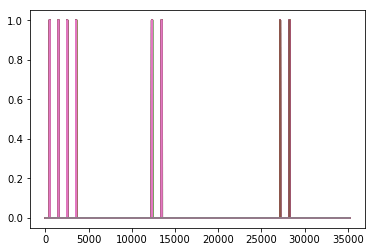

In [10]:
plt.figure();
plt.plot(x);

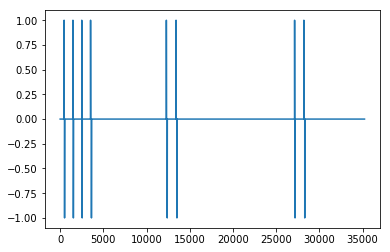

In [11]:
artifact_mask = sig.medfilt(x.any(1),3)
plt.plot(np.diff(artifact_mask))
stim_idxs = np.reshape(np.where(np.diff(artifact_mask,prepend=0)),(-1,2))

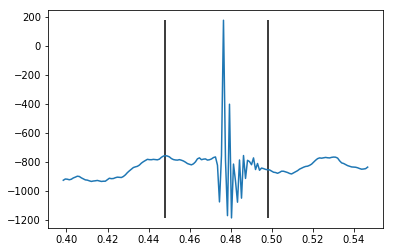

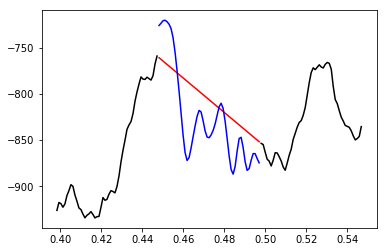

In [12]:
np.random.seed(42)
i_ch = 78
for win in [stim_idxs[0]]:
    win_len = win[1]-win[0]
    pre_idx = win[0] - win_len
    post_idx = win[1] + win_len
    
    # Plotting raw signal
    plot_seg = processed_seizure.iloc[pre_idx:post_idx,i_ch].to_numpy()
    plt.figure()
    plt.plot(t[np.arange(pre_idx,post_idx)],plot_seg)
    plt.vlines([(win_len + pre_idx)/fs, (2*win_len+pre_idx)/fs],plot_seg.min(),plot_seg.max())

    # Interpolation parameters
    s = processed_seizure.to_numpy()
    pre_idxs = np.arange(pre_idx,win[0])
    post_idxs = np.arange(win[1],post_idx)
    fill_idxs = np.arange(win[0],win[1])

    # Interpolation
    interp_fn = sc.interpolate.interp1d(np.concatenate([t[pre_idxs],t[post_idxs]]),
                             np.concatenate([s[pre_idxs,i_ch],s[post_idxs,i_ch]]))
    filled_s = interp_fn(t[fill_idxs])

    # Adding noise to interpolation
    sample_std = np.std(np.concatenate([s[pre_idxs,i_ch],s[post_idxs,3]]))
    interp_samples = np.random.normal(filled_s,np.ones_like(filled_s)*sample_std)

    # Plotting interpolation
    plt.figure()
    plt.plot(t[pre_idxs],s[pre_idxs,i_ch],color='k')
    plt.plot(t[fill_idxs],filled_s,color='r')
    plt.plot(t[post_idxs],s[post_idxs,i_ch],color='k')
    plt.plot(t[fill_idxs],sc.ndimage.gaussian_filter1d(interp_samples,2),color='b')



In [13]:

# interp = LinearRegression()
s = processed_seizure.to_numpy()
pre_idxs = np.arange(pre_idx,win[0])
post_idxs = np.arange(win[1],post_idx)
fill_idxs = np.arange(win[0],win[1])


In [14]:
# # SKLEARN METHODOLOGY
# interp = GPR(kernel=ConstantKernel(1)*RBF(1))
# interp.fit(np.concatenate([t[pre_idxs],t[post_idxs]]).reshape(-1,1),np.concatenate([s[pre_idxs,:],s[post_idxs,:]]))
# filled_s = interp.sample_y(t[fill_idxs].reshape(-1,1))
# filled_pre = interp.predict(t[pre_idxs].reshape(-1,1))

In [15]:
# MANUAL
interp_fn = sc.interpolate.interp1d(np.concatenate([t[pre_idxs],t[post_idxs]]),
                             np.concatenate([s[pre_idxs,i_ch],s[post_idxs,i_ch]]))
filled_s = interp_fn(t[fill_idxs])

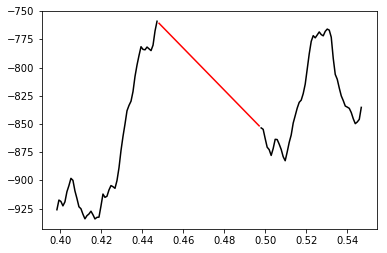

In [16]:
plt.plot(t[pre_idxs],s[pre_idxs,i_ch],color='k')
# plt.plot(t[pre_idxs],filled_pre[:,3],color='r')
plt.plot(t[fill_idxs],filled_s,color='r')
plt.plot(t[post_idxs],s[post_idxs,i_ch],color='k')

In [17]:
sample_std = np.std(np.concatenate([s[pre_idxs,i_ch],s[post_idxs,3]]))
interp_samples = np.random.normal(filled_s,np.ones_like(filled_s)*sample_std)

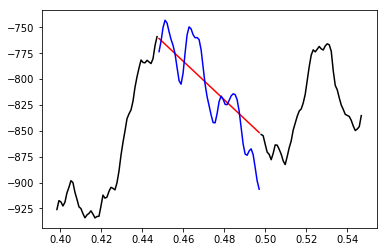

In [18]:
plt.plot(t[pre_idxs],s[pre_idxs,i_ch],color='k')
# plt.plot(t[pre_idxs],filled_pre[:,3],color='r')
plt.plot(t[fill_idxs],filled_s,color='r')
plt.plot(t[post_idxs],s[post_idxs,i_ch],color='k')
plt.plot(t[fill_idxs],sc.ndimage.gaussian_filter1d(interp_samples,2),color='b')